**About** : This notebook is used to train models.

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/workspace/kaggle_contrails/src


## Initialization

### Imports

In [3]:
import os
import torch

print(torch.__version__)
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.cuda.get_device_name(0)
print(device)

2.1.0a0+b5021ba
Tesla V100-SXM2-32GB-LS


In [7]:
import os
import sys
import glob
import json
# import timm
import torch
import operator
import warnings
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import *
# from numerize.numerize import numerize

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [11]:
from util.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    init_neptune
)

from params import *
from util.plots import *
from data.dataset import *
from data.transforms import get_transfos
from data.preparation import *
from util.torch import init_distributed, count_parameters, load_model_weights, count_parameters
from util.plots import plot_sample
# from model_zoo.models import define_model


# from training.main import k_fold

## Data

In [12]:
# df_split = prepare_folds()

In [13]:
df = prepare_data(DATA_PATH, processed_folder="false_color/", use_raw=True)

In [14]:
if "fold" not in df.columns:
    folds = pd.read_csv(DATA_PATH + "folds_4.csv")
    df = df.merge(folds)

### Dataset

In [15]:
df = df[df['has_contrail']].reset_index(drop=True)

In [23]:
transfos =  get_transfos(strength=0)
dataset = ContrailDataset(df, transfos, use_soft_mask=False, use_ext_data=False, frames=[0, 1, 2, 3, 4])

# transfos

In [24]:
%matplotlib inline

In [ ]:
for idx in np.random.choice(len(dataset), 3):
    idx = 0
    image, mask, y = dataset[idx]
    
    if len(image.size()) == 3:
        plot_sample(image.numpy().transpose(1, 2, 0), mask[:1].numpy().transpose(1, 2, 0) > 0.5)
    else:
        plot_sample(image[4].numpy().transpose(1, 2, 0).copy(), mask[:1].numpy().transpose(1, 2, 0) > 0.5)
#         plot_sample(image[4].numpy().transpose(1, 2, 0).copy(), mask[:1].numpy().transpose(1, 2, 0))

    break

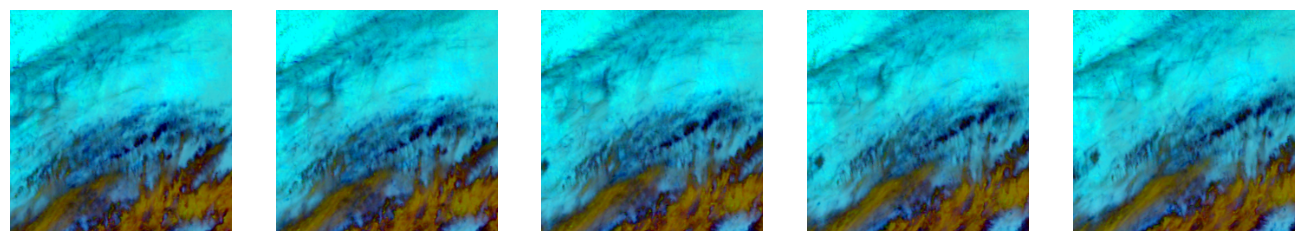

In [26]:
plt.figure(figsize=(20, 5))
for i, img in enumerate(image):
    plt.subplot(1, 6, i + 1)
    plt.imshow(img.numpy().transpose(1, 2, 0))
    plt.axis(False)
plt.show()

In [ ]:
# plot_sample(image[4].numpy().transpose(1, 2, 0).copy(), mask[:1].numpy().transpose(1, 2, 0) > 0.5)

In [ ]:
# for _ in range(5):
#     idx = np.random.choice(len(dataset))
#     image, mask, y = dataset[idx]

#     plt.figure(figsize=(20, 4))
#     for i, a in enumerate(mask[1:]):
#         plt.subplot(1, 6, i + 1)
#         plt.imshow(a.numpy())
#         plt.title(f'{a.max().item():.3f}')
#         plt.axis(False)
#     plt.show()

## Model

In [ ]:
model = define_model(
    "Unet",
    "convnextv2_nano",  # tf_efficientnetv2_s  seresnext26d_32x4d  convnextv2_nano
    reduce_stride=2,
    upsample=True,
    use_lstm=False,
    use_cnn=False,
#     pretrained_weights="../logs/2023-07-07/8/Unet_tf_efficientnetv2_s_0.pt",
    verbose=1,
    frames=4, # [0, 1, 2, 3, 4],
    kernel_size=(5, 3, 3),
    use_transfo=False,
    two_layers=True
)

In [ ]:
count_parameters(model)

In [ ]:
image, mask, y = dataset[0]

try:
    x = image.unsqueeze(0).repeat(2, 1, 1, 1)
except:
    x = image.unsqueeze(0).repeat(2, 1, 1, 1, 1)
    
x = x[:, -1]

In [ ]:
x.size()

In [ ]:
pred_mask, pred_cls = model(x)
pred_mask.size(), pred_cls.size()

In [ ]:
pred_mask, pred_cls = model(x)
pred_mask.size(), pred_cls.size()

In [ ]:
# # Find useless params

# opt = torch.optim.Adam(model.parameters())
# loss = pred_mask.mean()
# loss.backward()
# opt.step()
# for name, param in model.named_parameters():
#     if param.grad is None:
#         print(name)
    
# opt.zero_grad()

## Training

In [ ]:
class Config:
    """
    Parameters used for training
    """

    # General
    seed = 42
    verbose = 1
    device = "cuda"
    save_weights = True

    # Data
    processed_folder = "false_color/"
    size = 256
    aug_strength = 3
    use_soft_mask = True
    use_shape_descript = True

    # k-fold
    k = 4
    folds_file = f"../input/folds_{k}.csv"
    selected_folds = [0] #, 1, 2, 3]

    # Model
    encoder_name = "tf_efficientnetv2_s"  # tf_efficientnetv2_s seresnext50_32x4d efficientnetv2_rw_t convnextv2_tiny convnextv2_nano
    decoder_name = "Unet"

    pretrained_weights = None
    reduce_stride = 2
    use_pixel_shuffle = False
    use_hypercolumns = False
    center = "none"
    n_channels = 3
    num_classes = 7 if use_shape_descript else 1

    # Training
    loss_config = {
        "name": "lovasz_bce",  # bce lovasz_focal lovasz focal
        "smoothing": 0.,
        "activation": "sigmoid",
        "aux_loss_weight": 0.,
        "activation_aux": "sigmoid",
        "ousm_k": 0,
        "shape_loss_w": 1. if use_shape_descript else 0.
    }

    data_config = {
        "batch_size": 8,
        "val_bs": 16,
        "mix": "cutmix",
        "mix_proba": 0.5,
        "mix_alpha": 5,
        "additive_mix": True,
        "num_classes": num_classes
    }

    optimizer_config = {
        "name": "AdamW",
        "lr": 2e-4,
        "lr_encoder": 2e-4,
        "warmup_prop": 0.05,
        "betas": (0.9, 0.999),
        "max_grad_norm": 1.0,
        "weight_decay": 0.2,  # 0.05
    }

    epochs = 1
    two_stage = False

    use_fp16 = True
    model_soup = False

    verbose = 1
    verbose_eval = 200

    fullfit = False  # len(selected_folds) == 4
    n_fullfit = 1

In [ ]:
DEBUG = True
log_folder = None
run = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")
#     run = init_neptune(Config, log_folder)

df = prepare_data(DATA_PATH, Config.processed_folder)
init_distributed(Config)

preds = k_fold(Config, df, log_folder=log_folder, run=run)

Done ! 